In [1]:
dayStart = "2025-06-22"
dayEnd = "2025-06-29"

In [2]:
from enum import Enum
from sqlalchemy import create_engine, text #pip install sqlalchemy pg8000
from datetime import datetime
import json
import pandas as pd  # pip install pandas
import matplotlib.pyplot as plt # pip install seaborn
import seaborn as sns # pip install seaborn
import networkx as nx #pip install networkx pyvis
from pyvis.network import Network


# Replace with your actual DB config
DB_USER = 'theerawat'
DB_PASS = 'theerawat_123'
DB_HOST = '10.151.27.1'
DB_PORT = '5432'
# Table name you want to query
table_name = 'taskstate'

class ProductionLine(Enum):
    WB = 'robot_rmf_wb_db'
    DA = 'robot_rmf_da_db'
    ZING = 'robot_rmf_zing_db'
    
# Connect using pg8000 (pure Python)
def call_task_state_df(start_date_str, end_date_str, line: ProductionLine):
    db_name = str(line.value)
    data = []  # Collect dictionaries here

    query = f"""
        SELECT * FROM taskstate
        WHERE unix_millis_start_time > '{start_date_str} 00:00:00+07' 
          AND unix_millis_start_time < '{end_date_str} 23:59:59+07'
    """
    engine = create_engine(f'postgresql+pg8000://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{db_name}')
    with engine.connect() as conn:
        result = conn.execute(text(query))
        for row in result:
            datajson = row[1]
            
            start_ts = datajson.get("unix_millis_start_time")
            end_ts = datajson.get("unix_millis_finish_time")
            labels = datajson.get("booking", {}).get("labels") or []
            assigned_to = datajson.get("assigned_to", {}).get("name")
            state = row[7].replace("Status.", "") if row[7] is not None else None

            dts = datetime.fromtimestamp(start_ts / 1000) if start_ts else None
            dtf = datetime.fromtimestamp(end_ts / 1000) if end_ts else None
            formatted_date = dts.strftime("%d %b %Y") if dts else None

            details = {
                "Date": formatted_date,
                "Requester": row[8] if len(row) > 8 else None,
                "Pickup": labels[1].replace("pickup=", "") if len(labels) > 1 else None,
                "Destination": labels[2].replace("destination=", "") if len(labels) > 2 else None,
                "Robot": assigned_to,
                "StartTimeFormatted": dts,
                "EndTimeFormatted": dtf,
                "StartTime": start_ts,
                "EndTime": end_ts,
                "State": state,
                "Duration": (end_ts - start_ts) if start_ts and end_ts else None
            }
            data.append(details)
    
    # Convert list of dicts to DataFrame
    df = pd.DataFrame(data)
    return df

df = call_task_state_df(dayStart, dayEnd, ProductionLine.WB)
df = df.rename(columns={"StartTime": "StartTimeUnix", "EndTime": "EndTimeUnix"})
df = df.rename(columns={"StartTimeFormatted": "StartTime", "EndTimeFormatted": "EndTime"})

#df.tail(1)  # Inspect the DataFrame

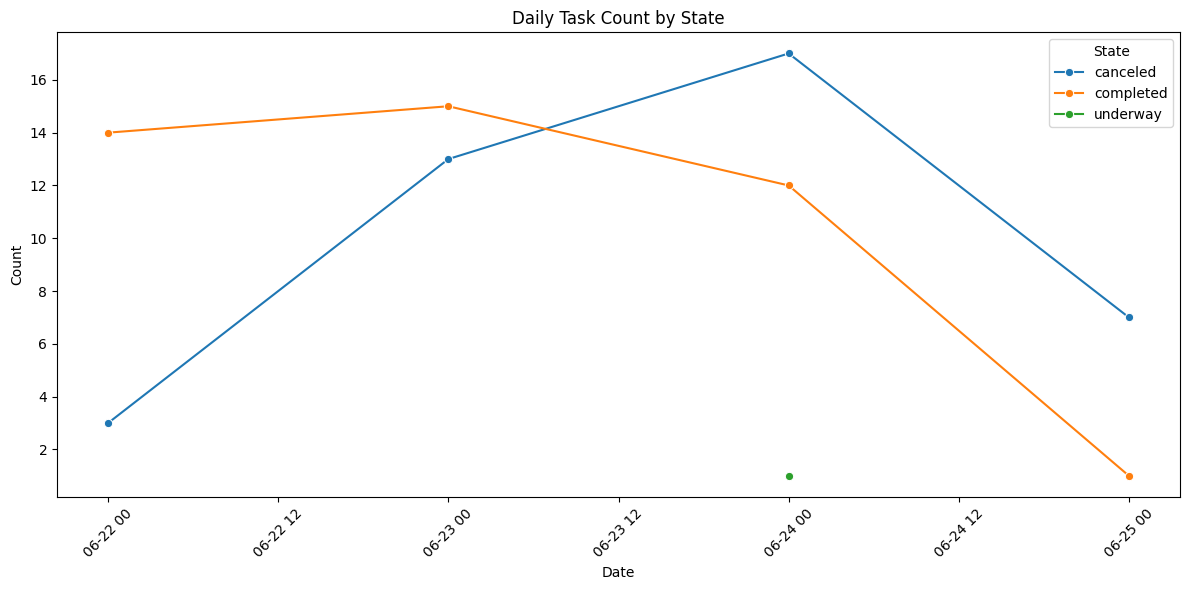

In [3]:
# Visualization 1: Daily Task Count by State
plt.figure(figsize=(12, 6))
daily_counts = (
    df.groupby([pd.to_datetime(df["Date"]), "State"]) #df.groupby([pd.to_datetime(df["Date"], format="%Y-%m-%d"), "State"])#  
    .size()
    .reset_index(name="Count")
)
sns.lineplot(
    data=daily_counts,
    x=pd.to_datetime(daily_counts["Date"]),
    y="Count",
    hue="State",
    marker="o",
)
plt.title("Daily Task Count by State")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Daily_Task_Count_by_State.png',dpi=300, bbox_inches='tight')
plt.show()

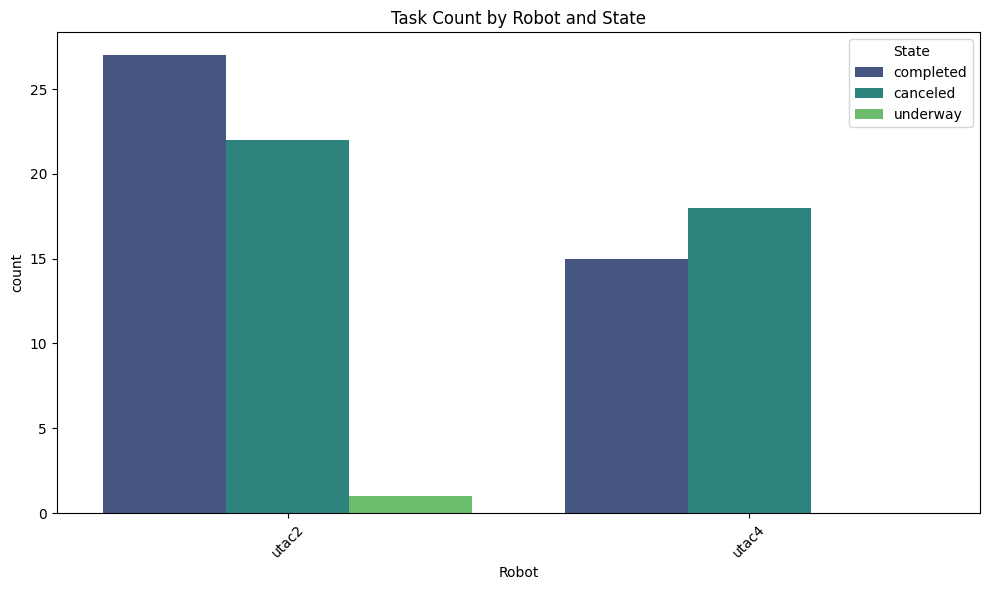

In [4]:
# Visualization 2: Task Distribution by Robot and State
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Robot", hue="State", palette="viridis")
plt.title("Task Count by Robot and State")
plt.xlabel("Robot")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Task_Count_by Robot_and_State.png',dpi=300, bbox_inches='tight')
plt.show()

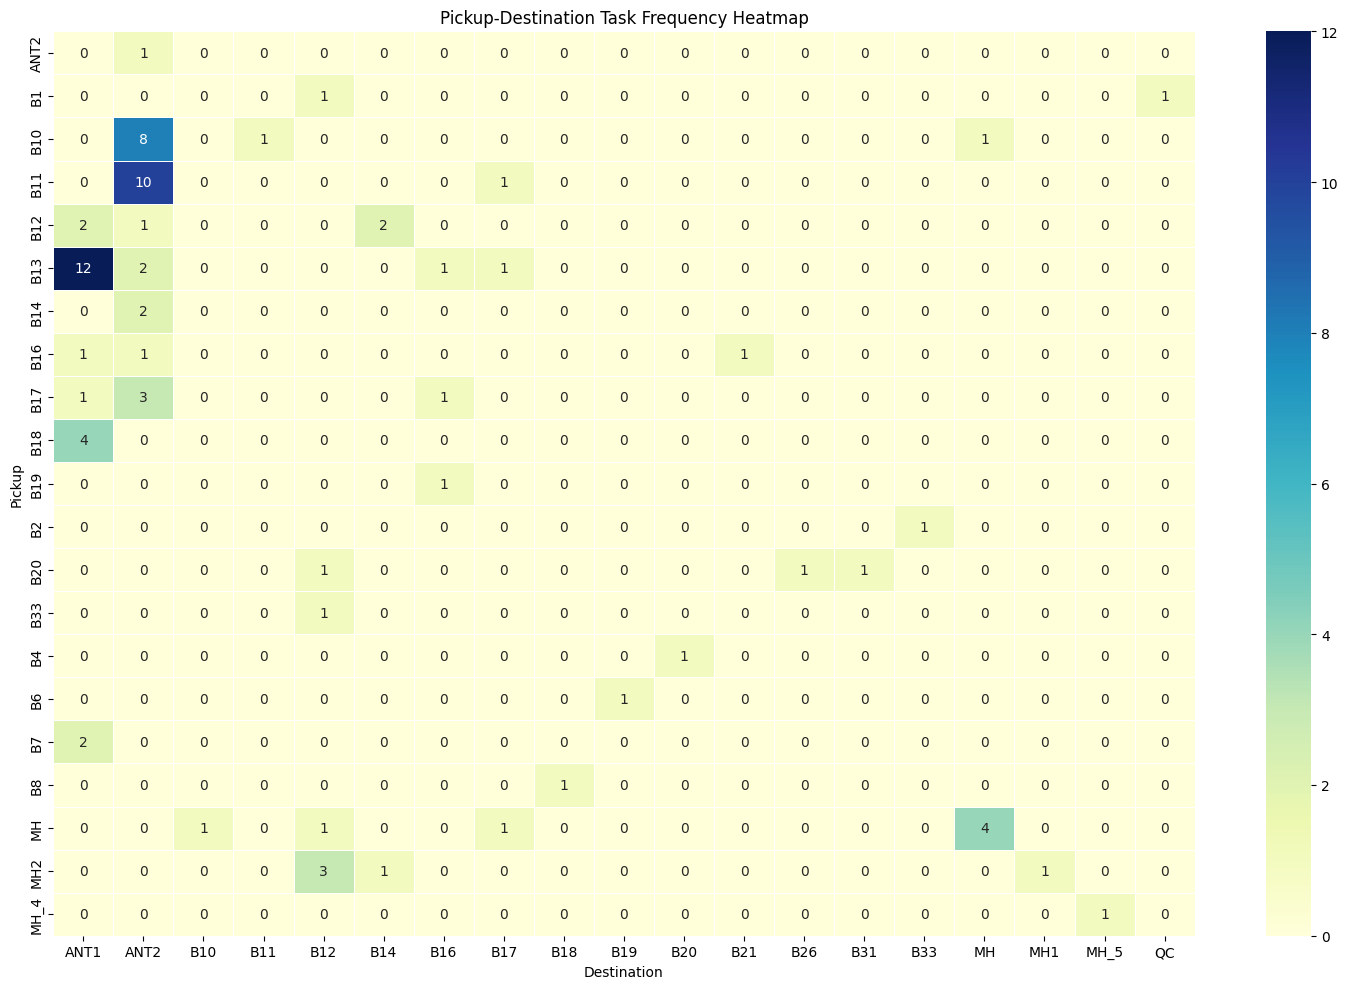

In [5]:
# Visualization 3: Prepare data for heatmap
heatmap_data = df.groupby(['Pickup', 'Destination']).size().unstack().fillna(0)

plt.figure(figsize=(15, 10))
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    annot=True,  # Show counts in cells
    fmt=".0f",
    linewidths=0.5
)
plt.title("Pickup-Destination Task Frequency Heatmap")
plt.xlabel("Destination")
plt.ylabel("Pickup")
plt.tight_layout()
plt.savefig('Pickup-Destination_Task_Frequency_Heatmap.png',dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# Visualization 4: Create a graph
G = nx.from_pandas_edgelist(
    df.groupby(['Pickup', 'Destination']).size().reset_index(name='Weight'),
    source='Pickup',
    target='Destination',
    edge_attr='Weight'
)

# Visualize with PyVis
net = Network(notebook=True, height="600px", width="100%")
net.from_nx(G)
net.show_buttons(filter_=['physics'])
net.show("network.html")  # Generates an interactive HTML file

network.html


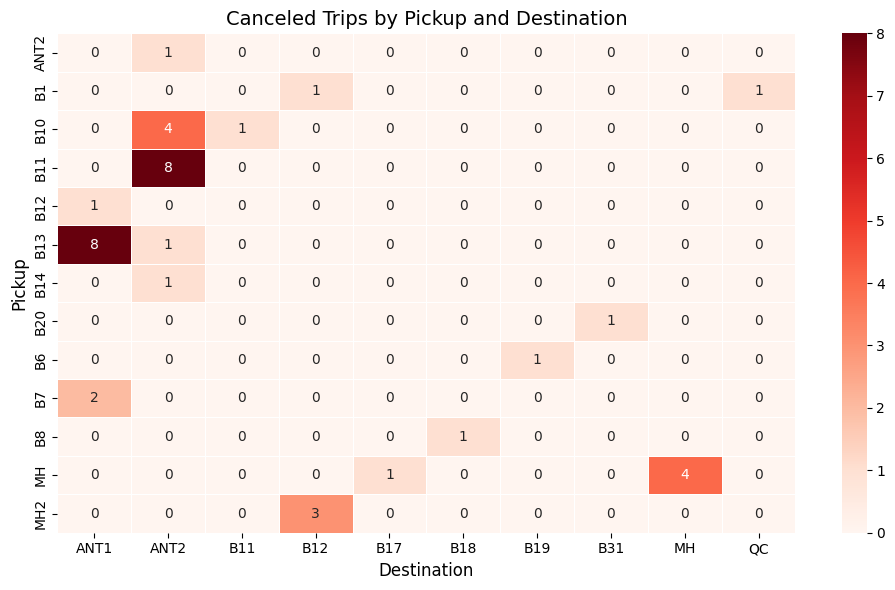

In [7]:
# Visualization 4: Filter canceled states
canceled_df = df[df['State'] == 'canceled']

# Create cross-tabulation
cross_tab = pd.crosstab(
    canceled_df['Pickup'],
    canceled_df['Destination']
)

# Generate heatmap
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(
    cross_tab, 
    annot=True, 
    fmt='d',
    cmap='Reds',
    linewidths=0.5
)
plt.title('Canceled Trips by Pickup and Destination', fontsize=14)
plt.xlabel('Destination', fontsize=12)
plt.ylabel('Pickup', fontsize=12)

# Export and display
plt.tight_layout()
plt.savefig('canceled_trips_heatmap.png', dpi=300)
plt.show()

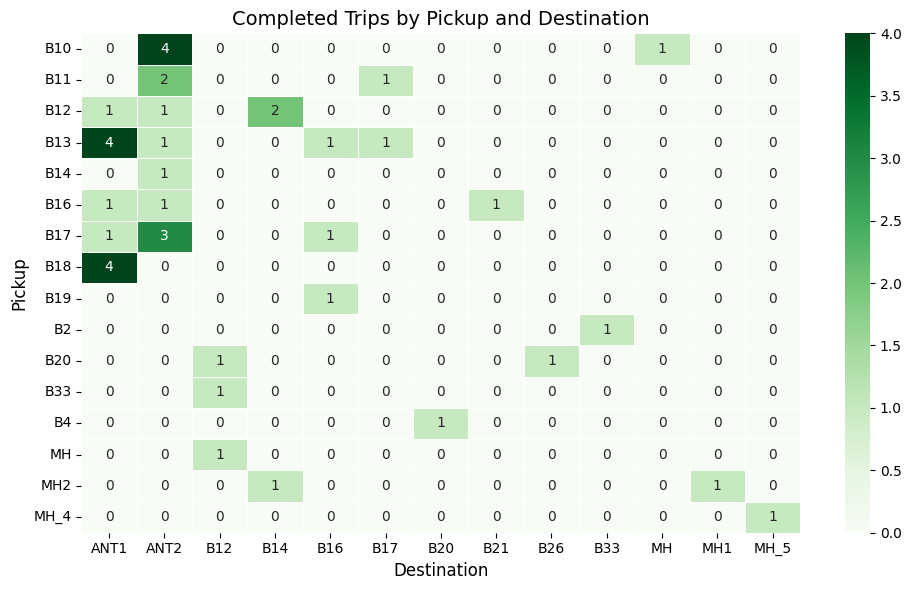

In [8]:
# Visualization 4: Filter completed states
canceled_df = df[df['State'] == 'completed']

# Create cross-tabulation
cross_tab = pd.crosstab(
    canceled_df['Pickup'],
    canceled_df['Destination']
)

# Generate heatmap
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(
    cross_tab, 
    annot=True, 
    fmt='d',
    cmap='Greens',
    linewidths=0.5
)
plt.title('Completed Trips by Pickup and Destination', fontsize=14)
plt.xlabel('Destination', fontsize=12)
plt.ylabel('Pickup', fontsize=12)

# Export and display
plt.tight_layout()
plt.savefig('completed_trips_heatmap.png', dpi=300)
plt.show()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           83 non-null     object        
 1   Requester      83 non-null     object        
 2   Pickup         83 non-null     object        
 3   Destination    83 non-null     object        
 4   Robot          83 non-null     object        
 5   StartTime      83 non-null     datetime64[ns]
 6   EndTime        81 non-null     datetime64[ns]
 7   StartTimeUnix  83 non-null     int64         
 8   EndTimeUnix    81 non-null     float64       
 9   State          83 non-null     object        
 10  Duration       81 non-null     float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 7.3+ KB


In [10]:
df.to_csv('data.csv', index=False)